In [ ]:
# DATASET LINK: https://www.kaggle.com/datasets/mikoajfish99/lions-or-cheetahs-image-classification

In [61]:
import os
import random
import shutil
import numpy as np
import tensorflow as tf
from shutil import copyfile
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import RMSprop

In [43]:
root_dir = './data/'

if os.path.exists(root_dir):
    shutil.rmtree(root_dir)

def create_train_val_dirs(root_dir):
    os.makedirs(os.path.join(root_dir, 'training/cheetahs'))
    os.makedirs(os.path.join(root_dir, 'training/lions'))
    os.makedirs(os.path.join(root_dir, 'validation/cheetahs'))
    os.makedirs(os.path.join(root_dir, 'validation/lions'))

create_train_val_dirs(root_dir)

In [44]:
def print_subdirectories(root_dir):
    for root, dirs, files in os.walk(root_dir):
        for name in dirs:
            print(os.path.join(root, name))

print_subdirectories(root_dir)

./data/validation
./data/training
./data/validation/cheetahs
./data/validation/lions
./data/training/cheetahs
./data/training/lions


In [45]:
def split_data(SOURCE_DIR, TRAIN_DIR, VALIDATION_DIR, SPLIT_SIZE):

    all_files = []

    for file in os.listdir(SOURCE_DIR):
        if os.path.getsize(os.path.join(SOURCE_DIR, file)) > 0:
            all_files.append(file)
        else:
            print(f'{file} is zero length, so ignoring')
    
    all_files = random.sample(all_files, len(all_files))

    SPLIT_POINT = int(len(all_files)*SPLIT_SIZE)

    train_files = all_files[:SPLIT_POINT]
    validation_files = all_files[SPLIT_POINT:]

    for file in train_files:
        src = os.path.join(SOURCE_DIR, file)
        dest = os.path.join(TRAIN_DIR, file)
        copyfile(src, dest)
    
    for file in validation_files:
        src = os.path.join(SOURCE_DIR, file)
        dest = os.path.join(VALIDATION_DIR, file)
        copyfile(src, dest)

In [46]:
CHEETAH_SOURCE_DIR = './images/Cheetahs'
LION_SOURCE_DIR = './images/Lions'

CHEETAH_TRAIN_DIR = './data/training/cheetahs'
LION_TRAIN_DIR = './data/training/lions'

CHEETAH_VALIDATION_DIR = './data/validation/cheetahs'
LION_VALIDATION_DIR = './data/validation/lions'

split_size = 0.9

split_data(CHEETAH_SOURCE_DIR, CHEETAH_TRAIN_DIR, CHEETAH_VALIDATION_DIR, split_size)
split_data(LION_SOURCE_DIR, LION_TRAIN_DIR, LION_VALIDATION_DIR, split_size)

print(f'Original cheetah images: {len(os.listdir(CHEETAH_SOURCE_DIR))}')
print(f'Original lion images: {len(os.listdir(LION_SOURCE_DIR))}')
print('\n\n')
print(f'Training cheetah images: {len(os.listdir(CHEETAH_TRAIN_DIR))}')
print(f'Training lion images: {len(os.listdir(LION_TRAIN_DIR))}')
print(f'Validation cheetah images: {len(os.listdir(CHEETAH_VALIDATION_DIR))}')
print(f'Validation lion images: {len(os.listdir(LION_VALIDATION_DIR))}')

Original cheetah images: 100
Original lion images: 100



Training cheetah images: 90
Training lion images: 90
Validation cheetah images: 10
Validation lion images: 10


In [51]:
def train_val_gens(TRAINING_DIR, VALIDATION_DIR):

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    train_generator = train_datagen.flow_from_directory(
        TRAINING_DIR,
        batch_size=20,
        class_mode='binary',
        target_size=(150, 150)
    )

    validation_datagen = ImageDataGenerator(rescale=1./255)

    validation_generator = validation_datagen.flow_from_directory(
        VALIDATION_DIR,
        batch_size=20,
        class_mode='binary',
        target_size=(150, 150)
    )

    return train_generator, validation_generator

In [52]:
train_generator, validation_generator = train_val_gens('./data/training', './data/validation')

Found 180 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [57]:
def create_model():

    pre_trained_model = InceptionV3(input_shape=(150, 150, 3),
                                    include_top=False,
                                    weights='imagenet')
    
    for layer in pre_trained_model.layers:
        layer.trainable = False

    last_layer = pre_trained_model.get_layer('mixed7')
    last_output = last_layer.output

    x = tf.keras.layers.Flatten()(last_output)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.models.Model(pre_trained_model.input, x)

    model.compile(
        optimizer=RMSprop(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
model = create_model()

In [91]:
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_294 (Conv2D) │ (None, 74, 74,    │        864 │ input_layer_7[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 74, 74,    │         96 │ conv2d_294[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_282      │ (None, 74, 74,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_295 (Conv2D) │ (None, 72, 72,    │      9,216 │ activation_282[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │         96 │ conv2d_295[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_283      │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_296 (Conv2D) │ (None, 72, 72,    │     18,432 │ activation_283[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        192 │ conv2d_296[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_284      │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_24    │ (None, 35, 35,    │          0 │ activation_284[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_297 (Conv2D) │ (None, 35, 35,    │      5,120 │ max_pooling2d_24… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        240 │ conv2d_297[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_285      │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_298 (Conv2D) │ (None, 33, 33,    │    138,240 │ activation_285[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 33,    │        576 │ conv2d_298[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_286      │ (None, 33, 33,    │          0 │ batch_normalizat

 Total params: 86,049,700 (328.25 MB)

 Trainable params: 38,537,217 (147.01 MB)

 Non-trainable params: 8,975,264 (34.24 MB)

 Optimizer params: 38,537,219 (147.01 MB)

In [60]:
history = model.fit(train_generator,
                    epochs=15,
                    validation_data=validation_generator,
                    verbose=1
                    )

Epoch 1/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 286ms/step - accuracy: 0.4708 - loss: 1.6125 - val_accuracy: 0.8500 - val_loss: 0.3722
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9814 - loss: 0.1206 - val_accuracy: 0.9000 - val_loss: 0.2838
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9903 - loss: 0.0424 - val_accuracy: 0.8500 - val_loss: 0.2678
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 1.0000 - loss: 0.0233 - val_accuracy: 0.9000 - val_loss: 0.2536
Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9957 - loss: 0.0173 - val_accuracy: 0.8500 - val_loss: 0.2659
Epoch 6/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 1.0000 - loss: 0.0115 - val_accuracy: 0.8500 - val_loss: 0.2885
Epoch 7/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 1.0000 - loss: 0.0051 - val_accuracy: 0.9500 - val_loss: 0.2522
Epoch 8/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 0.9500 - val_loss: 0.2520

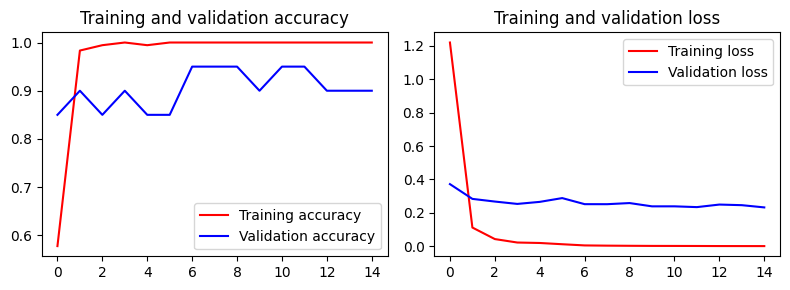

In [90]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(train_acc))

plt.figure(figsize=(8, 3))

plt.subplot(1,2,1)
plt.plot(epochs, train_acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.tight_layout()